In [35]:
#get dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import keras
import preprocessing

In [36]:
#set seed
seed = 42
np.random.seed(seed)
keras.utils.set_random_seed(seed)

In [37]:
dataset = np.load('../data/dataset.npz',)
X, y = dataset['X'], dataset['y']
print(X.shape, y.shape)

(9834, 400) (9834,)


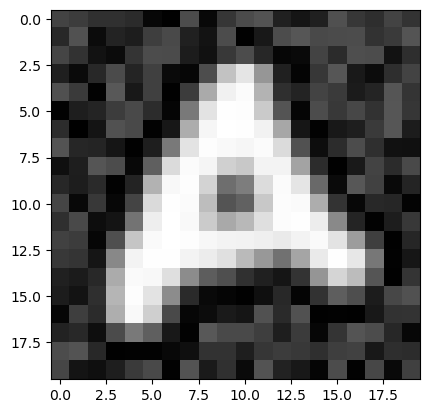

In [38]:
#k = range(0,16)

plt.imshow(X[0].reshape(20,20), vmin=0, vmax=255, cmap="gray")
plt.show()

# Model testing

In [55]:
from sklearn.model_selection import train_test_split

#split data
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,train_size=.7,random_state=seed)
X_val,X_test,y_val,y_test = train_test_split(X_val_test,y_val_test, train_size=.5, random_state=seed)

print(X_train.shape,y_train.shape,X_val.shape)

(6883, 400) (6883,) (1475, 400)


# SVM

In [40]:
#quick and dirty >:)
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
#want proba for each cat
svm = SVC(probability=True)
print(X_train.shape)
hyper_params = {
    'C' : [1e3, 1e2, 1e1, 1e0],
    'gamma' : [0.0001,0.001,0.1,1],
    'kernel' : ['rbf','poly'],
    #'coef0' : [0, 1, 2],
}

rscv = RandomizedSearchCV(estimator=svm,
                    random_state=seed,
                    param_distributions=hyper_params,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=2,
                    cv = 5
                    )


rscv.fit(X_train,y_train)

print(f"Best parameters: {rscv.best_params_}")
print(f"Best cross-validation score: {rscv.best_score_}")

(6883, 400)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time=  22.8s
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time=  23.0s
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time=  23.1s
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time=  23.2s
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time=  23.2s
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time=  23.3s
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time=  23.4s
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time=  23.7s
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time=  21.6s
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time=  21.6s
[CV] END ..................C=10.0, gamma=0.0001, kernel=poly; total time=  22.2s
[CV] END ..................C=10.0, g

In [41]:
from sklearn.metrics import accuracy_score

best_svm = rscv.best_estimator_

y_pred = best_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"accuracy_score (on val): {accuracy:.2f}")

accuracy_score (on val): 0.90


# Using balanced dataset (w/ generated)

In [56]:
from preprocessing import generate_balanced_data
#print(X_train.shape,y_train.shape)
X_train_aug, y_train_aug = generate_balanced_data(X_train, y_train, seed=seed)
print(X_train_aug.shape)

(11747, 400)


In [43]:
svm_aug = SVC(probability=True)

hyper_params = {
    'C' : [1e3, 1e2, 1e1, 1e0],
    'gamma' : [0.0001,0.001,0.1,1],
    'kernel' : ['rbf','poly'],
    #'coef0' : [0, 1, 2],
}

rscv = RandomizedSearchCV(estimator=svm_aug,
                    random_state=seed,
                    param_distributions=hyper_params,
                    #param_grid=hyper_params,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=2,
                    cv = 5
                    )


rscv.fit(X_train_aug,y_train_aug)

print(f"Best parameters: {rscv.best_params_}")
print(f"Best cross-validation score: {rscv.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time= 1.1min
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time= 1.2min
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time= 1.2min
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time= 1.2min
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time= 1.2min
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time= 1.2min
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time= 1.2min
[CV] END ......................C=1.0, gamma=0.1, kernel=poly; total time= 1.2min
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time= 1.1min
[CV] END ......................C=100.0, gamma=1, kernel=poly; total time= 1.2min
[CV] END ..................C=10.0, gamma=0.0001, kernel=poly; total time= 1.2min
[CV] END ..................C=10.0, gamma=0.0001,

In [60]:
best_svm_aug= rscv.best_estimator_
y_pred_aug = best_svm_aug.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_aug)
print(f"accuracy_score (on val w/ aug): {accuracy:.2f}")


accuracy_score (on val w/ aug): 0.89


# Some troch/keras testing

In [44]:
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import keras
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
#import tensorflow

#reshape to single images 20x20
X_train = X_train.reshape(X_train.shape[0], 20, 20, 1)
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 20, 20, 1)
X_val = X_val.reshape(X_val.shape[0], 20, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 20, 1)

#might need reshape somehow ;--)
#print(y_train[:16])

#y_train = y_train.reshape

#found online, rly cool func! (to_categorical)
y_train = keras.utils.to_categorical(y_train, num_classes=17)
y_val = keras.utils.to_categorical(y_val, num_classes=17)
y_train_aug = keras.utils.to_categorical(y_train_aug, num_classes=17)

#-----

cnn = keras.Sequential()
#add convulutional layer, filter should be pow2 (4 converging)
cnn.add(Convolution2D(filters=16, kernel_size=(3,3), activation='relu', input_shape = (20,20,1)))
print(cnn.output_shape)
#add pooling layer (Downsampling)
cnn.add(MaxPooling2D(pool_size=(2,2)))
print(cnn.output_shape)
cnn.add(Convolution2D(filters=32,kernel_size=(3,3), activation='relu'))
print(cnn.output_shape)
cnn.add(MaxPooling2D(pool_size=(2,2)))
print(cnn.output_shape)
#flatten outpu
cnn.add(Flatten())
#fully connected layer / back to std NN (kinda)
cnn.add(Dense(128, activation='relu'))
#dropout ensures no slacking!!
cnn.add(Dropout(rate=.2))
#output layer (softmax for probas)
cnn.add(Dense(17,activation='softmax'))
print(cnn.output_shape)
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn.fit(X_train,y_train, epochs=10)
score = cnn.evaluate(X_val,y_val,verbose=1)


(None, 18, 18, 16)
(None, 9, 9, 16)
(None, 7, 7, 32)
(None, 3, 3, 32)
(None, 17)
Epoch 1/10
216/216 [==============================] - 1s 2ms/step - loss: 3.9131 - accuracy: 0.4255
Epoch 2/10
216/216 [==============================] - 0s 2ms/step - loss: 0.8740 - accuracy: 0.7405
Epoch 3/10
216/216 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.8196
Epoch 4/10
216/216 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8629
Epoch 5/10
216/216 [==============================] - 1s 3ms/step - loss: 0.3514 - accuracy: 0.8864
Epoch 6/10
216/216 [==============================] - 1s 2ms/step - loss: 0.2857 - accuracy: 0.9061
Epoch 7/10
216/216 [==============================] - 1s 2ms/step - loss: 0.2273 - accuracy: 0.9247
Epoch 8/10
216/216 [==============================] - 1s 2ms/step - loss: 0.2090 - accuracy: 0.9323
Epoch 9/10
216/216 [==============================] - 1s 3ms/step - loss: 0.1838 - accuracy: 0.9393
Epoch 10/10
47/47 [

In [45]:
print(f"Score on val data: loss = {score[0]}, metric = {score[1]} ")

Score on val data: loss = 0.2537826895713806, metric = 0.9261016845703125 


# with augmented data

In [46]:
#yo hello
cnn.fit(X_train_aug,y_train_aug, epochs=10)
score_aug = cnn.evaluate(X_val,y_val,verbose=1)

Epoch 1/10
368/368 [==============================] - 1s 2ms/step - loss: 0.5000 - accuracy: 0.8480
Epoch 2/10
368/368 [==============================] - 1s 2ms/step - loss: 0.3647 - accuracy: 0.8844
Epoch 3/10
368/368 [==============================] - 1s 2ms/step - loss: 0.3071 - accuracy: 0.8981
Epoch 4/10
368/368 [==============================] - 1s 3ms/step - loss: 0.2584 - accuracy: 0.9176
Epoch 5/10
368/368 [==============================] - 1s 2ms/step - loss: 0.2272 - accuracy: 0.9257
Epoch 6/10
368/368 [==============================] - 1s 2ms/step - loss: 0.2015 - accuracy: 0.9307
Epoch 7/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1930 - accuracy: 0.9359
Epoch 8/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1732 - accuracy: 0.9425
Epoch 9/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1563 - accuracy: 0.9453
Epoch 10/10
47/47 [==============================] - 0s 872us/step - loss: 0.1783 - accuracy: 0.9532

In [51]:
print(f"Score on val data(w/aug): loss = {score_aug[0]}, metric = {score_aug[1]} ")

Score on val data(w/aug): loss = 0.17834694683551788, metric = 0.9532203674316406 
